# ECE 4194 Final Project. Spring 2019. The Ohio State University
## Authors: Michael Wharton.124, Alex Whitman.97, Benji Justice.251

This notebook is to train a resnet model to classify the actions specified in the dataset linked below.

Dataset: http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions



### Define packages to autoreload

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport models.resnet
%aimport utils.data_helpers

### Import necessary modules

In [3]:
# torch modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# import model
from models.resnet import resnet18, resnet34

# data functions
from utils.data_helpers import load_data
from utils.data_helpers import har_dataset

# classics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

### Define model hyper parameters

In [4]:
# what percentage of data should be used for training 
split = 0.7

num_epoch = 1000
lr = 1e-7
batch_size = 10
num_workers = 1

### Handle GPU

In [5]:
use_gpu=True
if torch.cuda.is_available() and use_gpu:
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor
    
    device = torch.device('cuda:0')
    
else:
    dtype = torch.FloatTensor
    ltype = torch.LongTensor
    device = torch.device('cpu')
    
print('device {} dtype {}'.format(device, dtype))

device cuda:0 dtype <class 'torch.cuda.FloatTensor'>


### Load data

In [6]:
# ...
train_data, train_labels, test_data, test_labels = load_data()


In [7]:
# convert to torch Tensor objects
train_data = torch.Tensor(train_data)
train_labels = torch.Tensor(train_labels)

test_data = torch.Tensor(test_data)
test_labels = torch.Tensor(test_labels)

In [8]:
print(train_data.shape)
print(test_data.shape)

print(train_labels.shape)
print(test_labels.shape)

torch.Size([873, 2048, 6])
torch.Size([341, 2048, 6])
torch.Size([873])
torch.Size([341])


In [9]:
best_acc_list = []

drop_prob_list = [0.1] #, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.0]
num_tests = len(drop_prob_list)

results = np.zeros(shape=(num_tests, num_epoch, 2, 2))

### Train !

In [10]:
for test_num, drop_prob in enumerate(drop_prob_list):
    print('\ndrop prob {}'.format(drop_prob))
    
    # create model
    model = resnet34(drop_prob=drop_prob)
    model = model.to(device)
    
    # Handle loss function and optimizer
    crit = torch.nn.CrossEntropyLoss()
    opt  = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

    # used to track the loss and accuracy over each epoch
    stats = np.zeros(shape=(num_epoch, 2, 2))

    # indices
    train = 0
    test  = 1
    acc   = 0
    loss  = 1

    # handle training and testing dataloaders
    train_ds = har_dataset(train_data, train_labels)
    train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers,shuffle=True)
    train_batches = train_dl.__len__()

    test_ds = har_dataset(test_data, test_labels)
    test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)
    test_batches = test_dl.__len__()

    best_acc = 0
    tstart = time.time()
    for epoch in range(num_epoch):

        # switch to train mode
        model.train()

        # track accuracy
        total = 0
        correct = 0

        # track loss
        tr_loss = []
        for batch, data in enumerate(train_dl):
            print('Training Iteration: {0:4d} of {1:4d}'.format(batch+1, train_batches), end='\r')

            # extract signal and labels
            signals, labels = data

            ## Normalize?

            # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
            signals = signals.transpose(1,2)

            # move data to device
            signals = signals.to(device)
            labels = labels.type(ltype).to(device)

            # process signals
            out = model(signals)

            # hard decision for classification
            _, pred = torch.max(out.data, 1)

            # compute accuracy
            total   += labels.size(0)
            correct += (pred == labels).sum().item()

            # compute loss
            b_loss = crit(out, labels)
            opt.zero_grad()
            b_loss.backward()
            opt.step()

            tr_loss.append(b_loss.item())

        # epoch training stats
        tr_accuracy = 100. * correct / total
        tr_loss = np.mean(tr_loss)

        # evaluate model
        model.eval()

        ts_loss = []
        total   = 0
        correct = 0
        with torch.no_grad():
            for batch, data in enumerate(test_dl):
                print('Testing  Iteration:: {0:4d} or {1:4d}'.format(batch+1, test_batches), end='\r')

                # extract signals and labels
                signals, labels = data

                # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
                signals = signals.transpose(1,2)

                # move data to device
                signals = signals.to(device)
                labels = labels.type(ltype).to(device)

                # process signals
                out = model(signals)

                # hard decision for classification
                _, pred = torch.max(out.data, 1)

                # compute accuracy
                total   += labels.size(0)
                correct += (pred == labels).sum().item()

                # compute loss
                b_loss = crit(out, labels)

                ts_loss.append(b_loss.item())
    
        # epoch testing stats
        ts_accuracy = 100. * correct / total
        ts_loss = np.mean(ts_loss)

        string=''
        if ts_accuracy > best_acc:
            best_acc = ts_accuracy
            string = 'save!'
            
        # save stats to plot later
        stats[epoch, train, loss ] = tr_loss
        stats[epoch, train, acc  ] = tr_accuracy
        stats[epoch, test,  loss ] = ts_loss
        stats[epoch, test,  acc  ] = ts_accuracy

        t1 = time.time() - tstart
        print('Epoch: {0:4d} Tr loss: {1:.3f} Ts loss: {2:.3f} Tr Accuracy: {3:3.2f}% Ts Accuracy: {4:3.2f}% Time: {5:4.2f}s p={6:0.2f} {7:s}'.format(
                epoch+1,      tr_loss,         ts_loss,         tr_accuracy,           ts_accuracy, t1, drop_prob, string))
    
    # save results of each model to plot
    results[test_num,:,:,:] = stats
    best_acc_list.append(best_acc)
    
np.savez('dropout_test',res=results)


drop prob 0.1
Epoch:    1 Tr loss: 3.248 Ts loss: 2.676 Tr Accuracy: 7.10% Ts Accuracy: 12.32% Time: 3.48s p=0.10 save!
Epoch:    2 Tr loss: 3.151 Ts loss: 2.632 Tr Accuracy: 7.56% Ts Accuracy: 13.49% Time: 6.25s p=0.10 save!
Epoch:    3 Tr loss: 3.050 Ts loss: 2.615 Tr Accuracy: 9.16% Ts Accuracy: 10.85% Time: 9.04s p=0.10 
Epoch:    4 Tr loss: 3.043 Ts loss: 2.576 Tr Accuracy: 6.99% Ts Accuracy: 9.38% Time: 11.85s p=0.10 
Epoch:    5 Tr loss: 2.961 Ts loss: 2.553 Tr Accuracy: 9.28% Ts Accuracy: 13.78% Time: 14.75s p=0.10 save!
Epoch:    6 Tr loss: 2.868 Ts loss: 2.504 Tr Accuracy: 9.16% Ts Accuracy: 15.84% Time: 17.52s p=0.10 save!
Epoch:    7 Tr loss: 2.852 Ts loss: 2.494 Tr Accuracy: 9.28% Ts Accuracy: 17.01% Time: 20.28s p=0.10 save!
Epoch:    8 Tr loss: 2.795 Ts loss: 2.468 Tr Accuracy: 9.05% Ts Accuracy: 15.84% Time: 23.04s p=0.10 
Epoch:    9 Tr loss: 2.740 Ts loss: 2.442 Tr Accuracy: 10.31% Ts Accuracy: 15.84% Time: 25.79s p=0.10 
Epoch:   10 Tr loss: 2.694 Ts loss: 2.457 Tr 

Epoch:   79 Tr loss: 1.772 Ts loss: 1.882 Tr Accuracy: 34.82% Ts Accuracy: 41.06% Time: 220.11s p=0.10 save!
Epoch:   80 Tr loss: 1.769 Ts loss: 1.899 Tr Accuracy: 33.91% Ts Accuracy: 39.30% Time: 222.89s p=0.10 
Epoch:   81 Tr loss: 1.721 Ts loss: 1.982 Tr Accuracy: 39.06% Ts Accuracy: 34.02% Time: 225.73s p=0.10 
Epoch:   82 Tr loss: 1.737 Ts loss: 1.906 Tr Accuracy: 35.74% Ts Accuracy: 41.64% Time: 228.47s p=0.10 save!
Epoch:   83 Tr loss: 1.718 Ts loss: 1.940 Tr Accuracy: 35.74% Ts Accuracy: 36.66% Time: 231.22s p=0.10 
Epoch:   84 Tr loss: 1.715 Ts loss: 1.947 Tr Accuracy: 37.00% Ts Accuracy: 40.47% Time: 233.97s p=0.10 
Epoch:   85 Tr loss: 1.728 Ts loss: 1.887 Tr Accuracy: 34.82% Ts Accuracy: 43.11% Time: 236.80s p=0.10 save!
Epoch:   86 Tr loss: 1.715 Ts loss: 1.906 Tr Accuracy: 37.92% Ts Accuracy: 43.99% Time: 239.56s p=0.10 save!
Epoch:   87 Tr loss: 1.680 Ts loss: 1.916 Tr Accuracy: 40.09% Ts Accuracy: 39.30% Time: 242.32s p=0.10 
Epoch:   88 Tr loss: 1.684 Ts loss: 1.930 Tr

Epoch:  157 Tr loss: 1.400 Ts loss: 1.724 Tr Accuracy: 48.00% Ts Accuracy: 46.33% Time: 436.96s p=0.10 
Epoch:  158 Tr loss: 1.397 Ts loss: 1.830 Tr Accuracy: 49.94% Ts Accuracy: 40.47% Time: 439.71s p=0.10 
Epoch:  159 Tr loss: 1.376 Ts loss: 1.754 Tr Accuracy: 49.94% Ts Accuracy: 46.33% Time: 442.51s p=0.10 
Epoch:  160 Tr loss: 1.411 Ts loss: 1.596 Tr Accuracy: 48.00% Ts Accuracy: 51.03% Time: 445.34s p=0.10 save!
Epoch:  161 Tr loss: 1.369 Ts loss: 1.704 Tr Accuracy: 50.52% Ts Accuracy: 45.16% Time: 448.07s p=0.10 
Epoch:  162 Tr loss: 1.390 Ts loss: 1.689 Tr Accuracy: 50.06% Ts Accuracy: 46.33% Time: 450.81s p=0.10 
Epoch:  163 Tr loss: 1.373 Ts loss: 1.776 Tr Accuracy: 50.29% Ts Accuracy: 43.70% Time: 453.56s p=0.10 
Epoch:  164 Tr loss: 1.366 Ts loss: 1.680 Tr Accuracy: 50.97% Ts Accuracy: 46.63% Time: 456.43s p=0.10 
Epoch:  165 Tr loss: 1.351 Ts loss: 1.606 Tr Accuracy: 50.97% Ts Accuracy: 50.73% Time: 459.15s p=0.10 
Epoch:  166 Tr loss: 1.364 Ts loss: 1.718 Tr Accuracy: 49.6

Epoch:  236 Tr loss: 1.186 Ts loss: 1.561 Tr Accuracy: 57.04% Ts Accuracy: 49.85% Time: 654.79s p=0.10 
Epoch:  237 Tr loss: 1.175 Ts loss: 1.559 Tr Accuracy: 56.36% Ts Accuracy: 52.79% Time: 657.50s p=0.10 
Epoch:  238 Tr loss: 1.182 Ts loss: 1.558 Tr Accuracy: 57.73% Ts Accuracy: 48.68% Time: 660.41s p=0.10 
Epoch:  239 Tr loss: 1.178 Ts loss: 1.514 Tr Accuracy: 58.42% Ts Accuracy: 50.44% Time: 663.17s p=0.10 
Epoch:  240 Tr loss: 1.204 Ts loss: 1.493 Tr Accuracy: 56.36% Ts Accuracy: 54.84% Time: 665.94s p=0.10 
Epoch:  241 Tr loss: 1.171 Ts loss: 1.498 Tr Accuracy: 59.68% Ts Accuracy: 54.55% Time: 668.71s p=0.10 
Epoch:  242 Tr loss: 1.178 Ts loss: 1.517 Tr Accuracy: 55.90% Ts Accuracy: 52.79% Time: 671.43s p=0.10 
Epoch:  243 Tr loss: 1.165 Ts loss: 1.548 Tr Accuracy: 58.30% Ts Accuracy: 51.91% Time: 674.14s p=0.10 
Epoch:  244 Tr loss: 1.162 Ts loss: 1.543 Tr Accuracy: 58.30% Ts Accuracy: 53.08% Time: 676.88s p=0.10 
Epoch:  245 Tr loss: 1.208 Ts loss: 1.486 Tr Accuracy: 55.56% Ts

Epoch:  315 Tr loss: 1.094 Ts loss: 1.462 Tr Accuracy: 59.68% Ts Accuracy: 50.73% Time: 871.94s p=0.10 
Epoch:  316 Tr loss: 1.051 Ts loss: 1.443 Tr Accuracy: 62.77% Ts Accuracy: 50.44% Time: 874.70s p=0.10 
Epoch:  317 Tr loss: 1.052 Ts loss: 1.345 Tr Accuracy: 62.89% Ts Accuracy: 53.08% Time: 877.40s p=0.10 
Epoch:  318 Tr loss: 1.042 Ts loss: 1.466 Tr Accuracy: 63.92% Ts Accuracy: 53.67% Time: 880.13s p=0.10 
Epoch:  319 Tr loss: 1.079 Ts loss: 1.462 Tr Accuracy: 59.79% Ts Accuracy: 48.68% Time: 882.84s p=0.10 
Epoch:  320 Tr loss: 1.092 Ts loss: 1.315 Tr Accuracy: 61.86% Ts Accuracy: 56.60% Time: 885.55s p=0.10 
Epoch:  321 Tr loss: 1.063 Ts loss: 1.292 Tr Accuracy: 61.17% Ts Accuracy: 56.89% Time: 888.42s p=0.10 
Epoch:  322 Tr loss: 1.053 Ts loss: 1.402 Tr Accuracy: 62.89% Ts Accuracy: 55.43% Time: 891.19s p=0.10 
Epoch:  323 Tr loss: 1.044 Ts loss: 1.446 Tr Accuracy: 63.00% Ts Accuracy: 50.15% Time: 893.94s p=0.10 
Epoch:  324 Tr loss: 1.036 Ts loss: 1.434 Tr Accuracy: 61.28% Ts

Epoch:  394 Tr loss: 0.971 Ts loss: 1.362 Tr Accuracy: 65.06% Ts Accuracy: 52.79% Time: 1088.84s p=0.10 
Epoch:  395 Tr loss: 0.950 Ts loss: 1.437 Tr Accuracy: 65.41% Ts Accuracy: 50.73% Time: 1091.57s p=0.10 
Epoch:  396 Tr loss: 0.943 Ts loss: 1.233 Tr Accuracy: 66.67% Ts Accuracy: 60.41% Time: 1094.35s p=0.10 
Epoch:  397 Tr loss: 1.001 Ts loss: 1.293 Tr Accuracy: 64.15% Ts Accuracy: 55.13% Time: 1097.05s p=0.10 
Epoch:  398 Tr loss: 0.967 Ts loss: 1.292 Tr Accuracy: 65.75% Ts Accuracy: 55.13% Time: 1099.73s p=0.10 
Epoch:  399 Tr loss: 0.980 Ts loss: 1.218 Tr Accuracy: 66.67% Ts Accuracy: 57.18% Time: 1102.41s p=0.10 
Epoch:  400 Tr loss: 0.943 Ts loss: 1.303 Tr Accuracy: 65.52% Ts Accuracy: 53.67% Time: 1105.10s p=0.10 
Epoch:  401 Tr loss: 0.935 Ts loss: 1.211 Tr Accuracy: 66.55% Ts Accuracy: 59.82% Time: 1107.82s p=0.10 
Epoch:  402 Tr loss: 0.957 Ts loss: 1.352 Tr Accuracy: 67.12% Ts Accuracy: 52.20% Time: 1110.56s p=0.10 
Epoch:  403 Tr loss: 0.962 Ts loss: 1.306 Tr Accuracy: 

Epoch:  472 Tr loss: 0.870 Ts loss: 1.159 Tr Accuracy: 69.19% Ts Accuracy: 61.58% Time: 1303.06s p=0.10 
Epoch:  473 Tr loss: 0.868 Ts loss: 1.157 Tr Accuracy: 70.10% Ts Accuracy: 60.70% Time: 1305.78s p=0.10 
Epoch:  474 Tr loss: 0.868 Ts loss: 1.257 Tr Accuracy: 71.36% Ts Accuracy: 58.36% Time: 1308.53s p=0.10 
Epoch:  475 Tr loss: 0.862 Ts loss: 1.212 Tr Accuracy: 71.13% Ts Accuracy: 60.12% Time: 1311.26s p=0.10 
Epoch:  476 Tr loss: 0.864 Ts loss: 1.239 Tr Accuracy: 70.68% Ts Accuracy: 53.96% Time: 1313.98s p=0.10 
Epoch:  477 Tr loss: 0.846 Ts loss: 1.262 Tr Accuracy: 70.22% Ts Accuracy: 57.18% Time: 1316.74s p=0.10 
Epoch:  478 Tr loss: 0.849 Ts loss: 1.163 Tr Accuracy: 68.04% Ts Accuracy: 61.58% Time: 1319.46s p=0.10 
Epoch:  479 Tr loss: 0.852 Ts loss: 1.110 Tr Accuracy: 68.61% Ts Accuracy: 62.76% Time: 1322.19s p=0.10 
Epoch:  480 Tr loss: 0.853 Ts loss: 1.268 Tr Accuracy: 70.68% Ts Accuracy: 55.13% Time: 1324.93s p=0.10 
Epoch:  481 Tr loss: 0.894 Ts loss: 1.185 Tr Accuracy: 

Epoch:  550 Tr loss: 0.771 Ts loss: 1.182 Tr Accuracy: 73.20% Ts Accuracy: 54.25% Time: 1516.44s p=0.10 
Epoch:  551 Tr loss: 0.795 Ts loss: 1.078 Tr Accuracy: 71.13% Ts Accuracy: 63.93% Time: 1519.16s p=0.10 
Epoch:  552 Tr loss: 0.820 Ts loss: 1.028 Tr Accuracy: 71.36% Ts Accuracy: 63.93% Time: 1521.88s p=0.10 
Epoch:  553 Tr loss: 0.761 Ts loss: 1.025 Tr Accuracy: 75.26% Ts Accuracy: 64.52% Time: 1524.61s p=0.10 
Epoch:  554 Tr loss: 0.765 Ts loss: 1.184 Tr Accuracy: 72.51% Ts Accuracy: 55.43% Time: 1527.33s p=0.10 
Epoch:  555 Tr loss: 0.802 Ts loss: 1.160 Tr Accuracy: 71.82% Ts Accuracy: 59.53% Time: 1530.09s p=0.10 
Epoch:  556 Tr loss: 0.790 Ts loss: 1.096 Tr Accuracy: 71.82% Ts Accuracy: 61.29% Time: 1532.93s p=0.10 
Epoch:  557 Tr loss: 0.791 Ts loss: 1.091 Tr Accuracy: 72.05% Ts Accuracy: 63.64% Time: 1535.67s p=0.10 
Epoch:  558 Tr loss: 0.768 Ts loss: 1.085 Tr Accuracy: 73.42% Ts Accuracy: 62.76% Time: 1538.39s p=0.10 
Epoch:  559 Tr loss: 0.776 Ts loss: 1.098 Tr Accuracy: 

Epoch:  628 Tr loss: 0.734 Ts loss: 0.999 Tr Accuracy: 73.77% Ts Accuracy: 64.22% Time: 1730.48s p=0.10 
Epoch:  629 Tr loss: 0.785 Ts loss: 0.970 Tr Accuracy: 73.42% Ts Accuracy: 66.28% Time: 1733.26s p=0.10 
Epoch:  630 Tr loss: 0.724 Ts loss: 0.954 Tr Accuracy: 75.37% Ts Accuracy: 64.81% Time: 1735.98s p=0.10 
Epoch:  631 Tr loss: 0.702 Ts loss: 1.136 Tr Accuracy: 76.63% Ts Accuracy: 59.82% Time: 1738.70s p=0.10 
Epoch:  632 Tr loss: 0.709 Ts loss: 1.050 Tr Accuracy: 74.91% Ts Accuracy: 64.52% Time: 1741.43s p=0.10 
Epoch:  633 Tr loss: 0.704 Ts loss: 0.952 Tr Accuracy: 76.40% Ts Accuracy: 67.45% Time: 1744.15s p=0.10 
Epoch:  634 Tr loss: 0.719 Ts loss: 0.976 Tr Accuracy: 74.91% Ts Accuracy: 66.28% Time: 1746.88s p=0.10 
Epoch:  635 Tr loss: 0.718 Ts loss: 1.002 Tr Accuracy: 74.80% Ts Accuracy: 65.10% Time: 1749.61s p=0.10 
Epoch:  636 Tr loss: 0.749 Ts loss: 1.130 Tr Accuracy: 72.51% Ts Accuracy: 60.12% Time: 1752.34s p=0.10 
Epoch:  637 Tr loss: 0.727 Ts loss: 0.938 Tr Accuracy: 

Epoch:  706 Tr loss: 0.654 Ts loss: 0.965 Tr Accuracy: 76.63% Ts Accuracy: 65.98% Time: 1944.78s p=0.10 
Epoch:  707 Tr loss: 0.682 Ts loss: 0.885 Tr Accuracy: 74.68% Ts Accuracy: 69.21% Time: 1947.56s p=0.10 
Epoch:  708 Tr loss: 0.672 Ts loss: 0.990 Tr Accuracy: 75.60% Ts Accuracy: 64.52% Time: 1950.31s p=0.10 
Epoch:  709 Tr loss: 0.700 Ts loss: 0.973 Tr Accuracy: 75.60% Ts Accuracy: 67.45% Time: 1953.09s p=0.10 
Epoch:  710 Tr loss: 0.693 Ts loss: 1.014 Tr Accuracy: 76.06% Ts Accuracy: 65.10% Time: 1955.86s p=0.10 
Epoch:  711 Tr loss: 0.685 Ts loss: 0.982 Tr Accuracy: 74.68% Ts Accuracy: 63.64% Time: 1958.57s p=0.10 
Epoch:  712 Tr loss: 0.671 Ts loss: 0.996 Tr Accuracy: 76.06% Ts Accuracy: 64.22% Time: 1961.36s p=0.10 
Epoch:  713 Tr loss: 0.672 Ts loss: 1.013 Tr Accuracy: 77.21% Ts Accuracy: 62.76% Time: 1964.18s p=0.10 
Epoch:  714 Tr loss: 0.679 Ts loss: 0.996 Tr Accuracy: 75.14% Ts Accuracy: 65.10% Time: 1966.91s p=0.10 
Epoch:  715 Tr loss: 0.685 Ts loss: 0.896 Tr Accuracy: 

Epoch:  784 Tr loss: 0.642 Ts loss: 0.934 Tr Accuracy: 76.40% Ts Accuracy: 67.16% Time: 2158.98s p=0.10 
Epoch:  785 Tr loss: 0.643 Ts loss: 0.890 Tr Accuracy: 76.52% Ts Accuracy: 66.86% Time: 2161.69s p=0.10 
Epoch:  786 Tr loss: 0.614 Ts loss: 0.816 Tr Accuracy: 79.84% Ts Accuracy: 71.85% Time: 2164.41s p=0.10 
Epoch:  787 Tr loss: 0.646 Ts loss: 0.916 Tr Accuracy: 75.72% Ts Accuracy: 67.74% Time: 2167.13s p=0.10 
Epoch:  788 Tr loss: 0.633 Ts loss: 0.983 Tr Accuracy: 76.98% Ts Accuracy: 65.10% Time: 2169.84s p=0.10 
Epoch:  789 Tr loss: 0.622 Ts loss: 0.899 Tr Accuracy: 77.55% Ts Accuracy: 67.45% Time: 2172.59s p=0.10 
Epoch:  790 Tr loss: 0.626 Ts loss: 0.833 Tr Accuracy: 76.86% Ts Accuracy: 71.26% Time: 2175.32s p=0.10 
Epoch:  791 Tr loss: 0.639 Ts loss: 0.863 Tr Accuracy: 76.29% Ts Accuracy: 70.38% Time: 2178.06s p=0.10 
Epoch:  792 Tr loss: 0.592 Ts loss: 0.869 Tr Accuracy: 79.27% Ts Accuracy: 68.33% Time: 2180.87s p=0.10 
Epoch:  793 Tr loss: 0.663 Ts loss: 0.937 Tr Accuracy: 

Epoch:  862 Tr loss: 0.612 Ts loss: 0.804 Tr Accuracy: 78.47% Ts Accuracy: 72.73% Time: 2372.87s p=0.10 
Epoch:  863 Tr loss: 0.588 Ts loss: 0.830 Tr Accuracy: 78.35% Ts Accuracy: 71.55% Time: 2375.62s p=0.10 
Epoch:  864 Tr loss: 0.588 Ts loss: 0.837 Tr Accuracy: 79.38% Ts Accuracy: 68.91% Time: 2378.37s p=0.10 
Epoch:  865 Tr loss: 0.594 Ts loss: 0.909 Tr Accuracy: 79.73% Ts Accuracy: 68.33% Time: 2381.12s p=0.10 
Epoch:  866 Tr loss: 0.603 Ts loss: 0.876 Tr Accuracy: 79.04% Ts Accuracy: 70.09% Time: 2383.97s p=0.10 
Epoch:  867 Tr loss: 0.606 Ts loss: 0.847 Tr Accuracy: 78.58% Ts Accuracy: 70.38% Time: 2386.69s p=0.10 
Epoch:  868 Tr loss: 0.618 Ts loss: 0.803 Tr Accuracy: 77.66% Ts Accuracy: 71.26% Time: 2389.41s p=0.10 
Epoch:  869 Tr loss: 0.607 Ts loss: 0.826 Tr Accuracy: 77.43% Ts Accuracy: 70.97% Time: 2392.15s p=0.10 
Epoch:  870 Tr loss: 0.566 Ts loss: 0.815 Tr Accuracy: 80.53% Ts Accuracy: 70.97% Time: 2394.88s p=0.10 
Epoch:  871 Tr loss: 0.582 Ts loss: 0.817 Tr Accuracy: 

Epoch:  940 Tr loss: 0.563 Ts loss: 0.993 Tr Accuracy: 79.73% Ts Accuracy: 65.10% Time: 2586.52s p=0.10 
Epoch:  941 Tr loss: 0.578 Ts loss: 0.858 Tr Accuracy: 79.38% Ts Accuracy: 69.50% Time: 2589.29s p=0.10 
Epoch:  942 Tr loss: 0.577 Ts loss: 0.809 Tr Accuracy: 80.99% Ts Accuracy: 73.31% Time: 2592.03s p=0.10 
Epoch:  943 Tr loss: 0.596 Ts loss: 0.752 Tr Accuracy: 78.92% Ts Accuracy: 74.78% Time: 2594.78s p=0.10 
Epoch:  944 Tr loss: 0.525 Ts loss: 0.900 Tr Accuracy: 79.38% Ts Accuracy: 69.50% Time: 2597.53s p=0.10 
Epoch:  945 Tr loss: 0.566 Ts loss: 0.840 Tr Accuracy: 78.58% Ts Accuracy: 71.26% Time: 2600.24s p=0.10 
Epoch:  946 Tr loss: 0.568 Ts loss: 0.731 Tr Accuracy: 80.41% Ts Accuracy: 75.37% Time: 2602.97s p=0.10 save!
Epoch:  947 Tr loss: 0.595 Ts loss: 0.836 Tr Accuracy: 78.81% Ts Accuracy: 70.38% Time: 2605.71s p=0.10 
Epoch:  948 Tr loss: 0.554 Ts loss: 0.787 Tr Accuracy: 78.81% Ts Accuracy: 73.02% Time: 2608.53s p=0.10 
Epoch:  949 Tr loss: 0.536 Ts loss: 0.808 Tr Accur

In [11]:
print(best_acc)

77.71260997067449


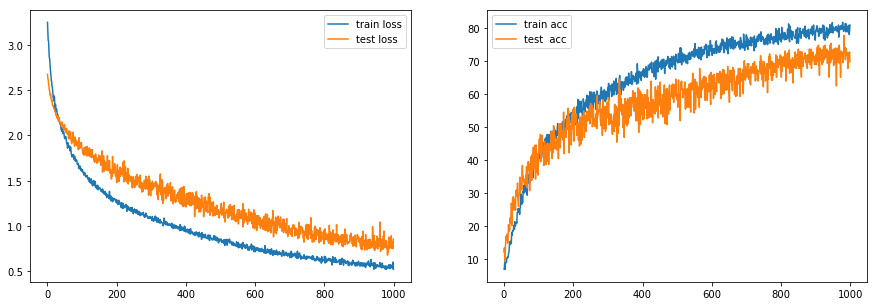

In [12]:
x = np.linspace(0,epoch,epoch+1)

tr_loss = stats[:,train,loss]
ts_loss = stats[:,test, loss]

tr_acc = stats[:, train, acc]
ts_acc = stats[:, test,  acc]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(x,tr_loss,label='train loss')
plt.plot(x,ts_loss,label='test loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,tr_acc,label='train acc')
plt.plot(x,ts_acc,label='test  acc')
plt.legend()

plt.show()

In [13]:
test_file = np.load('dropout_test.npz')['res']
test_data=test_file

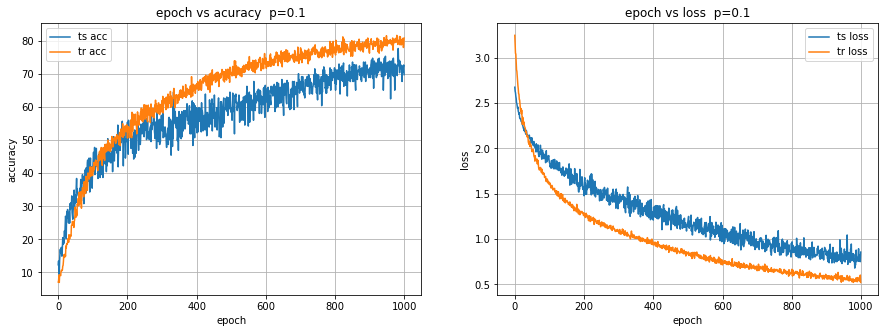

In [14]:
train = 0
test  = 1
acc   = 0
loss  = 1

x = np.linspace(0,epoch,epoch+1)
for i in range(len(drop_prob_list)):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    ts_a = test_file[i,:,test,acc]
    ts_l = test_file[i,:,test,loss]
    tr_a = test_file[i,:,train,acc]
    tr_l = test_file[i,:,train,loss]
    
    plt.plot(x,ts_a,label='ts acc')
    plt.plot(x,tr_a,label='tr acc')
    plt.title('epoch vs acuracy  p=' + str(drop_prob_list[i]))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(x,ts_l,label='ts loss')
    plt.plot(x,tr_l,label='tr loss')
    plt.title('epoch vs loss  p=' + str(drop_prob_list[i]))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    